In [1]:
#Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
#loading dataset
path = 'C:/Users/kenne/mvp_analysis/mvp_voting_'
try:
    start_year = str(int(input('Enter start year:')))
    end_year = str(int(input('Enter end year:')))
except ValueError:
    print("Invalid input. Please enter a valid integer.")

file_path = path + start_year + "_" + end_year + ".csv"
df = pd.read_csv(file_path)
df.head()

Enter start year: 2000
Enter end year: 2023


,Year,Name,Tm,Vote Pts,1st Place,Share,WAR,G,AB,R,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,Jason Giambi,OAK,317.0,14.0,81%,7.8,152.0,510.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,Frank Thomas,CHW,285.0,10.0,73%,6.0,159.0,582.0,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,Alex Rodriguez,SEA,218.0,4.0,56%,10.4,148.0,554.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,Carlos Delgado,TOR,206.0,0.0,53%,7.3,162.0,569.0,115.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Labeling more features
df['Lg'] = None #League (NL or AL)
df.insert(0, 'Lg', df.pop('Lg')) 

df['Pos_Int'] = None #Position (Pitcher = 0, Batter = 1)
df.insert(0, 'Pos_Int', df.pop('Pos_Int'))

df['Pos'] = None #Position (String)
df.insert(0, 'Pos', df.pop('Pos')) 

df['LgYear'] = None #League + Year
df.insert(0, 'LgYear', df.pop('LgYear')) 

df['IsMvp_Int'] = None #Is MVP (Yes = 1, No = 0)
df.insert(0, 'IsMvp_Int', df.pop('IsMvp_Int')) 

df['IsMvp'] = None #Is MVP (String)
df.insert(0, 'IsMvp', df.pop('IsMvp')) 

df['Rank'] = None #Rank amongst competition
df.insert(0, 'Rank', df.pop('Rank')) 

df.head()

,Rank,IsMvp,IsMvp_Int,LgYear,Pos,Pos_Int,Lg,Year,Name,Tm,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
0,None,None,None,None,None,None,None,2000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,None,None,None,None,None,2000,Jason Giambi,OAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,None,None,None,None,None,2000,Frank Thomas,CHW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,None,None,None,None,None,None,2000,Alex Rodriguez,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,None,None,None,None,None,None,2000,Carlos Delgado,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Classifying of said features
rnk = 0
lg = "NL"

for row in df.itertuples(index=True):
    year = row.Year
    name = row.Name
    index = row.Index
    era = row.ERA
    
    if pd.isna(name):
        rnk = 0
    df.at[index, 'Rank'] = rnk
    
    if (rnk == 1):
        df.at[index, 'IsMvp'] = "Yes"
        df.at[index, 'IsMvp_Int'] = 1
    else:
        df.at[index, 'IsMvp'] = "No"
        df.at[index, 'IsMvp_Int'] = 0

    if pd.isna(era):
        df.at[index, 'Pos'] = "Batter"
        df.at[index, 'Pos_Int'] = 1
    else:
        df.at[index, 'Pos'] = "Pitcher"
        df.at[index, 'Pos_Int'] = 0

    if pd.isna(name):
        if (lg == "NL"):
            lg = "AL"
        else:
            lg = "NL"
    df.at[index, 'Lg'] = lg
    df.at[index, 'LgYear'] = lg + str(year)[2:]

    rnk += 1

In [5]:
#Drop rows without a name
df.dropna(subset=['Name'], inplace=True)
df.head()

,Rank,IsMvp,IsMvp_Int,LgYear,Pos,Pos_Int,Lg,Year,Name,Tm,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
1,1,Yes,1,AL00,Batter,1,AL,2000,Jason Giambi,OAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,No,0,AL00,Batter,1,AL,2000,Frank Thomas,CHW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,No,0,AL00,Batter,1,AL,2000,Alex Rodriguez,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,No,0,AL00,Batter,1,AL,2000,Carlos Delgado,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,No,0,AL00,Pitcher,0,AL,2000,Pedro Martinez,BOS,...,1.74,0.737,29.0,29.0,0.0,217.0,128.0,17.0,32.0,284.0


In [6]:
#Write to new .csv file
file_path_2 = path + start_year + "_" + end_year + "_cleaned.csv"
df.to_csv(file_path_2, index=False)

In [7]:
df = pd.read_csv(file_path_2)
df.shape

(1206, 38)

In [8]:
al_mvp_winners = df[(df["IsMvp"] == "Yes") & (df["Lg"] == "AL")]
nl_mvp_winners = df[(df["IsMvp"] == "Yes") & (df["Lg"] == "NL")]

not_al_mvp_winners = df[(df["IsMvp"] == "No") & (df["Lg"] == "AL")]
not_nl_mvp_winners = df[(df["IsMvp"] == "No") & (df["Lg"] == "NL")]

not_al_mvp_winners_cnt = not_al_mvp_winners.groupby("Year").size()
not_nl_mvp_winners_cnt = not_nl_mvp_winners.groupby("Year").size()

#print(not_al_mvp_winners_cnt)
#print(not_nl_mvp_winners_cnt)

print("Avg number of AL non-winners in race from " + start_year + " to " + end_year + ": " + str(round(not_al_mvp_winners_cnt.mean(),2)))
print("Avg number of NL non-winners in race from " + start_year + " to " + end_year + ": " + str(round(not_nl_mvp_winners_cnt.mean(),2)))

Avg number of AL non-winners in race from 2000 to 2023: 23.54
Avg number of NL non-winners in race from 2000 to 2023: 24.71


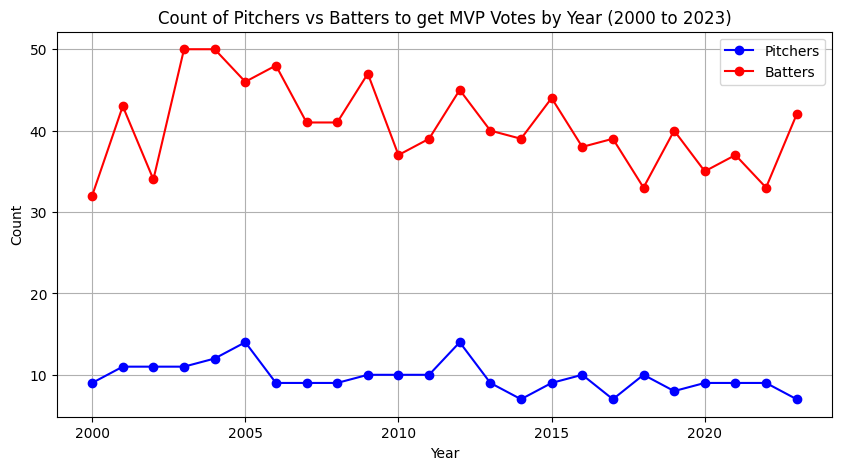

Correlation between pitcher count and batter count: 0.37581209170707436
Covariance between pitcher count and batter count: 3.643115942028985 



In [9]:
# Filter the df for pitchers and batters
pitchers = df[df["Pos"] == "Pitcher"]
batters = df[df["Pos"] == "Batter"]

# Group by year and count the number of pitchers and batters
pitcher_cnt = pitchers.groupby("Year").size()
batter_cnt = batters.groupby("Year").size()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(pitcher_cnt.index, pitcher_cnt.values, marker='o', linestyle='-', color='blue', label='Pitchers')
plt.plot(batter_cnt.index, batter_cnt.values, marker='o', linestyle='-', color='red', label='Batters')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Pitchers vs Batters to get MVP Votes by Year (' + start_year + " to " + end_year +")")
plt.legend()
plt.grid(True)
plt.show()

correlation = pitcher_cnt.corr(batter_cnt)
print("Correlation between pitcher count and batter count:", correlation)
covariance = pitcher_cnt.cov(batter_cnt)
print("Covariance between pitcher count and batter count:", covariance, "\n")

Correlation between pitcher counts between leagues: -0.0677623784108727
Covariance between pitcher counts between leagues: -0.11956521739130442 

Correlation between batter counts between leagues: 0.06630474018100206
Covariance between batter counts between leagues: 0.8731884057971012 



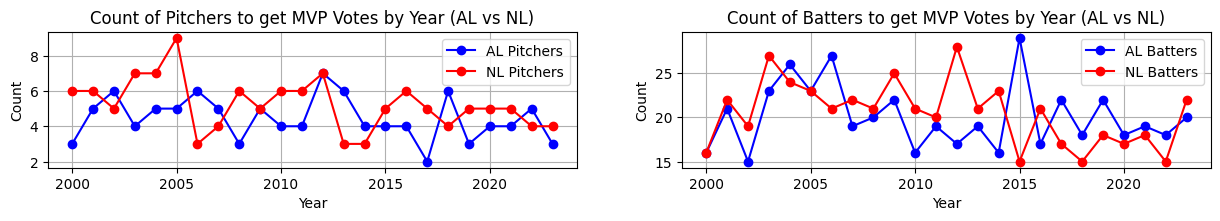

In [10]:

# Filter the DataFrame for AL and NL pitchers and batters
al_pitchers = df[(df["Pos"] == "Pitcher") & (df["Lg"] == "AL")]
nl_pitchers = df[(df["Pos"] == "Pitcher") &  (df["Lg"] == "NL")]

al_batters = df[(df["Pos"] == "Batter") &  (df["Lg"] == "AL")]
nl_batters = df[(df["Pos"] == "Batter") &  (df["Lg"] == "NL")]

# Group by year and count the number of pitchers and batters for AL and NL
al_pitcher_cnt = al_pitchers.groupby("Year").size()
nl_pitcher_cnt = nl_pitchers.groupby("Year").size()

al_batter_cnt = al_batters.groupby("Year").size()
nl_batter_cnt = nl_batters.groupby("Year").size()

# Plotting AL vs NL pitchers
plt.figure(figsize=(15, 6))

plt.subplot(3, 2, 1)
plt.plot(al_pitcher_cnt.index, al_pitcher_cnt.values, marker='o', linestyle='-', color='blue', label='AL Pitchers')
plt.plot(nl_pitcher_cnt.index, nl_pitcher_cnt.values, marker='o', linestyle='-', color='red', label='NL Pitchers')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Pitchers to get MVP Votes by Year (AL vs NL)')
plt.legend()
plt.grid(True)

# Plotting AL vs NL batters
plt.subplot(3, 2, 2)
plt.plot(al_batter_cnt.index, al_batter_cnt.values, marker='o', linestyle='-', color='blue', label='AL Batters')
plt.plot(nl_batter_cnt.index, nl_batter_cnt.values, marker='o', linestyle='-', color='red', label='NL Batters')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Batters to get MVP Votes by Year (AL vs NL)')
plt.legend()
plt.grid(True)

correlation = al_pitcher_cnt.corr(nl_pitcher_cnt)
print("Correlation between pitcher counts between leagues:", correlation)
covariance = al_pitcher_cnt.cov(nl_pitcher_cnt)
print("Covariance between pitcher counts between leagues:", covariance, "\n")

correlation = al_batter_cnt.corr(nl_batter_cnt)
print("Correlation between batter counts between leagues:", correlation)
covariance = al_batter_cnt.cov(nl_batter_cnt)
print("Covariance between batter counts between leagues:", covariance,"\n")

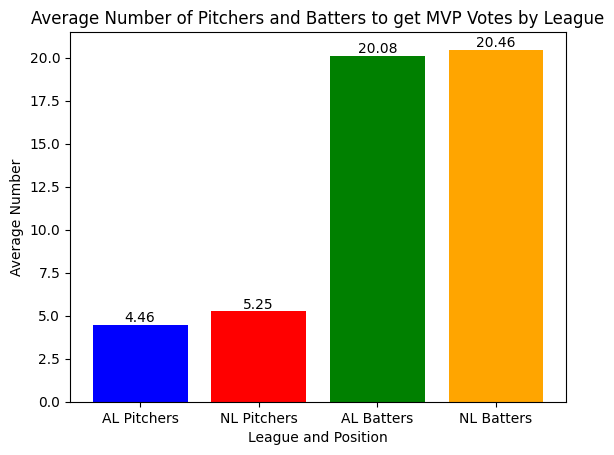

In [11]:
al_batter_avg = al_batter_cnt.mean()
nl_batter_avg = nl_batter_cnt.mean()
al_pitcher_avg = al_pitcher_cnt.mean()
nl_pitcher_avg = nl_pitcher_cnt.mean()

# Data for plotting
leagues = ['AL Pitchers', 'NL Pitchers', 'AL Batters', 'NL Batters']
averages = [al_pitcher_avg, nl_pitcher_avg, al_batter_avg, nl_batter_avg]

# Creating the bar plot
plt.bar(leagues, averages, color=['blue', 'red', 'green', 'orange'])
plt.xlabel('League and Position')
plt.ylabel('Average Number')
plt.title('Average Number of Pitchers and Batters to get MVP Votes by League')
# Adding numbers on the bars
for i, value in enumerate(averages):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')
plt.show()

In [12]:
df['IsMvp_Int'] = df['IsMvp_Int'].astype(int)

# Identify groups where the rank 1 player is a pitcher
pitcher_groups = df.groupby('LgYear').apply(lambda x: x.iloc[0]['Pos'] == 'Pitcher')

# Extract indices of groups where the rank 1 player is a pitcher
indices_to_remove = pitcher_groups[pitcher_groups].index

# Drop these indices from the DataFrame
df_filtered = df[~df['LgYear'].isin(indices_to_remove)]

# Now df_filtered contains the DataFrame with groups remove

df_filtered = df_filtered[df_filtered['Pos'] != 'Pitcher'] #filter out all pitchers

C:\Users\kenne\AppData\Local\Temp\ipykernel_11400\3462315898.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pitcher_groups = df.groupby('LgYear').apply(lambda x: x.iloc[0]['Pos'] == 'Pitcher')


In [13]:
df_filtered.head()

,Rank,IsMvp,IsMvp_Int,LgYear,Pos,Pos_Int,Lg,Year,Name,Tm,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
0,1,Yes,1,AL00,Batter,1,AL,2000,Jason Giambi,OAK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,No,0,AL00,Batter,1,AL,2000,Frank Thomas,CHW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,No,0,AL00,Batter,1,AL,2000,Alex Rodriguez,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,No,0,AL00,Batter,1,AL,2000,Carlos Delgado,TOR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,No,0,AL00,Batter,1,AL,2000,Edgar Martínez,SEA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df_filtered.drop(columns = ['ERA','WHIP','G.1','GS','SV','IP','H.1','HR.1','BB.1','SO', 'W', 
                                 'L', '1st Place', 'Name','Year','Lg','IsMvp','Pos','Pos_Int','Tm','Rank',
                                'Vote Pts', 'IsMvp_Int'])
df.head()

,LgYear,Share,WAR,G,AB,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS
0,AL00,81%,7.8,152.0,510.0,108.0,170.0,43.0,137.0,2.0,137.0,0.333,0.476,0.647,1.123
1,AL00,73%,6.0,159.0,582.0,115.0,191.0,43.0,143.0,1.0,112.0,0.328,0.436,0.625,1.061
2,AL00,56%,10.4,148.0,554.0,134.0,175.0,41.0,132.0,15.0,100.0,0.316,0.420,0.606,1.026
3,AL00,53%,7.3,162.0,569.0,115.0,196.0,41.0,137.0,0.0,123.0,0.344,0.470,0.664,1.134
5,AL00,25%,5.7,153.0,556.0,100.0,180.0,37.0,145.0,3.0,96.0,0.324,0.423,0.579,1.002


In [15]:
# Convert percentage strings into integers
df['Share'] = df['Share'].str.rstrip('%').astype(int)
df.head()

,LgYear,Share,WAR,G,AB,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS
0,AL00,81,7.8,152.0,510.0,108.0,170.0,43.0,137.0,2.0,137.0,0.333,0.476,0.647,1.123
1,AL00,73,6.0,159.0,582.0,115.0,191.0,43.0,143.0,1.0,112.0,0.328,0.436,0.625,1.061
2,AL00,56,10.4,148.0,554.0,134.0,175.0,41.0,132.0,15.0,100.0,0.316,0.420,0.606,1.026
3,AL00,53,7.3,162.0,569.0,115.0,196.0,41.0,137.0,0.0,123.0,0.344,0.470,0.664,1.134
5,AL00,25,5.7,153.0,556.0,100.0,180.0,37.0,145.0,3.0,96.0,0.324,0.423,0.579,1.002


In [16]:
# Define the columns to normalize
columns_to_normalize = ['Share','WAR', 'G', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'BB', 'BA', 'OBP', 'SLG', 'OPS']

# Define a function for normalization
def normalize(group):
    # Min-max normalization within each group
    return (group - group.min()) / (group.max() - group.min())

# Apply normalization within each group
df[columns_to_normalize] = df.groupby('LgYear')[columns_to_normalize].transform(normalize)

df.drop(columns=['LgYear'], inplace=True)
df.head()

,Share,WAR,G,AB,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS
0,1.000000,0.662338,0.772727,0.299578,0.404255,0.222222,1.000000,0.888889,0.043478,1.000000,0.597938,1.000000,0.770642,0.904908
1,0.901235,0.428571,0.931818,0.603376,0.553191,0.455556,1.000000,0.972222,0.021739,0.675325,0.546392,0.685039,0.669725,0.714724
2,0.691358,1.000000,0.681818,0.485232,0.957447,0.277778,0.928571,0.819444,0.326087,0.519481,0.422680,0.559055,0.582569,0.607362
3,0.654321,0.597403,1.000000,0.548523,0.553191,0.511111,0.928571,0.888889,0.000000,0.818182,0.711340,0.952756,0.848624,0.938650
5,0.308642,0.389610,0.795455,0.493671,0.234043,0.333333,0.785714,1.000000,0.065217,0.467532,0.505155,0.582677,0.458716,0.533742


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0635 - mae: 0.1996 - val_loss: 0.0426 - val_mae: 0.1640
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0440 - mae: 0.1585 - val_loss: 0.0397 - val_mae: 0.1457
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0434 - mae: 0.1535 - val_loss: 0.0395 - val_mae: 0.1467
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0372 - mae: 0.1464 - val_loss: 0.0387 - val_mae: 0.1439
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 - mae: 0.1443 - val_loss: 0.0421 - val_mae: 0.1471
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0354 - mae: 0.1342 - val_loss: 0.0378 - val_mae: 0.1417
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - mae: 0.1363 - val_loss: 0.0371 - val_mae: 0.1411
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - mae: 0.1279 - val_loss: 0.0374 - val_mae: 0.1408
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.03

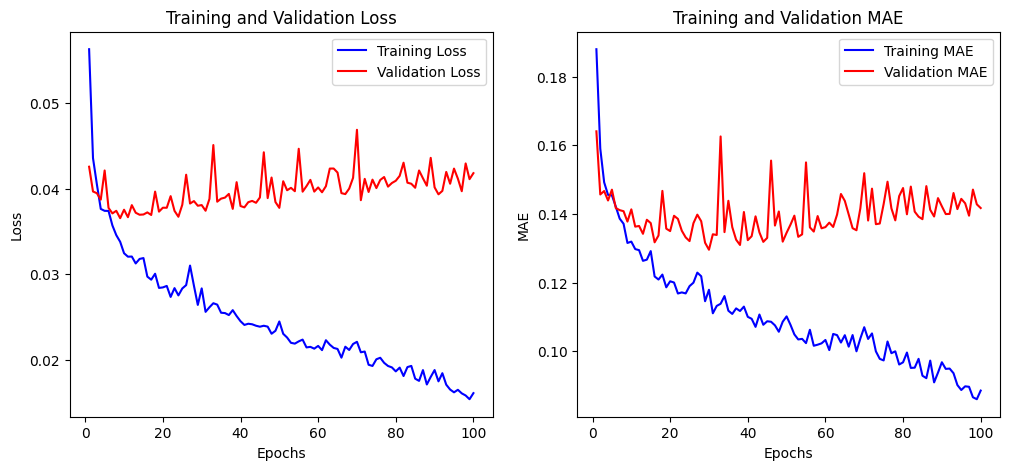

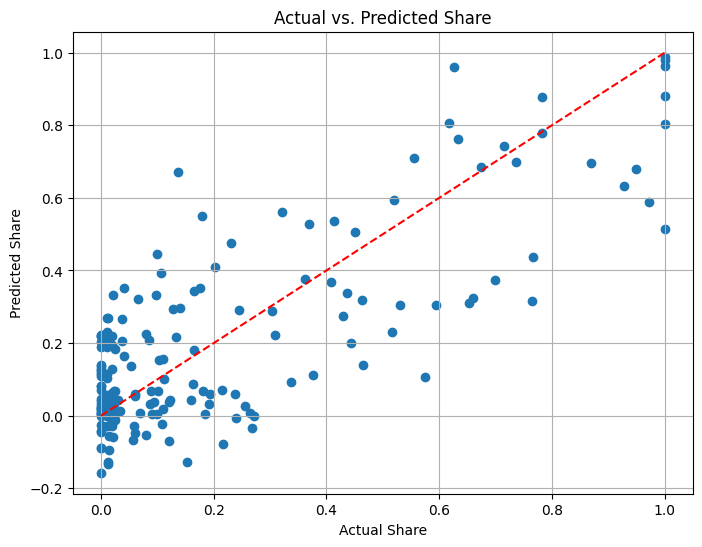

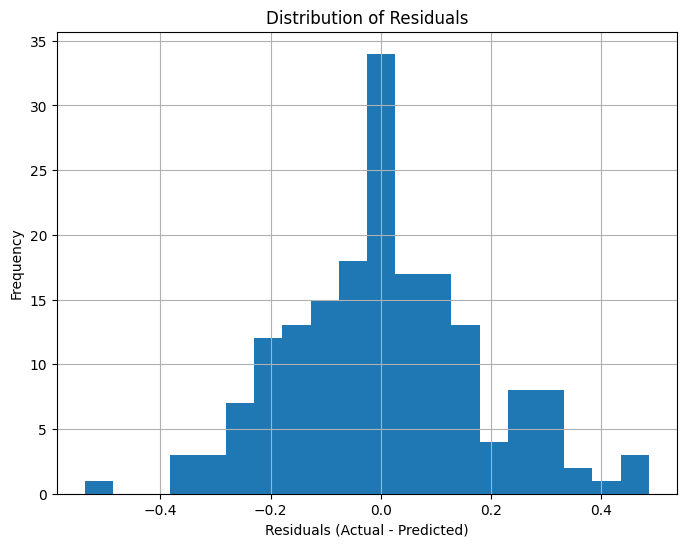

<Figure size 640x480 with 0 Axes>

Mean Absolute Error: 0.1324198991060257


In [17]:
# Define the features (X) and target variable (y)
X = df.drop(columns=['Share'])
y = df['Share']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)

import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Predict on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Calculate the residuals
residuals = y_test - y_pred

# Plot the predicted values against the actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
plt.xlabel('Actual Share')
plt.ylabel('Predicted Share')
plt.title('Actual vs. Predicted Share')
plt.grid(True)
plt.show()

# Plot the distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

plt.tight_layout()
plt.show()

print("Mean Absolute Error:", mae)